In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
!pip uninstall resampy
!pip install resampy

Found existing installation: resampy 0.4.2
Uninstalling resampy-0.4.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/resampy-0.4.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/resampy/*
Proceed (Y/n)? y
  Successfully uninstalled resampy-0.4.2
  Using cached resampy-0.4.2-py3-none-any.whl (3.1 MB)


In [ ]:
#Audio Processing Libraries
import librosa
import librosa.display
from scipy import signal

#For Playing Audios
import IPython.display as ipd

#Array Processing
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Display the confusion matrix
from sklearn.metrics import confusion_matrix

#Deal with .pkl files
import pickle

#Create a dataframe
import pandas as pd

#Transform and encode the categorical targets
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#Split dataset
from sklearn.model_selection import train_test_split

import os

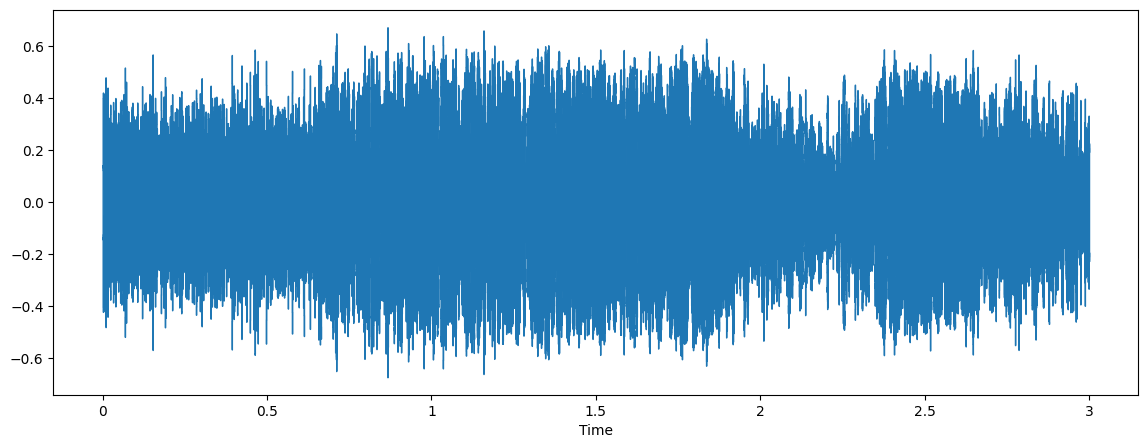

In [ ]:
filename = "/content/gdrive/MyDrive/SirenSound/sounds/firetruck/sound_201.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

In [ ]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

In [ ]:
audio_dataset_path = '/content/gdrive/MyDrive/SirenSound/sounds/'

extracted_features = []
for path in os.listdir(audio_dataset_path):
    for file in os.listdir(audio_dataset_path+path+"/"):
        if file.lower().endswith(".wav"):
            file_name = audio_dataset_path+path+"/"+file
            data = features_extractor(file_name)
            extracted_features.append([data, path])

In [ ]:
f = open('./Extracted_Features.pkl', 'wb')
pickle.dump(extracted_features, f)
f.close()

In [ ]:
f = open('./Extracted_Features.pkl', 'rb')
Data = pickle.load(f)
f.close()

In [ ]:
df = pd.DataFrame(Data,columns=['feature','class'])
df.head()

,feature,class
0,"[-38.777115, 104.3772, -40.953793, 1.848557, -...",ambulance
1,"[-118.98806, 113.261086, -38.593113, -1.789974...",ambulance
2,"[-529.2778, 96.091225, -46.660313, -12.780942,...",ambulance
3,"[-521.1548, 95.068886, -53.567135, -10.641551,...",ambulance
4,"[-164.77432, 126.585754, -35.331738, -14.74020...",ambulance


In [ ]:
df['class'].value_counts()

ambulance    200
firetruck    200
traffic      200
Name: class, dtype: int64

In [ ]:
X = np.array(df['feature'].tolist())
Y = np.array(df['class'].tolist())

In [ ]:
X.shape

(600, 80)

In [ ]:
Y.shape

(600,)

In [ ]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(Y))

In [ ]:
Y[0]

'ambulance'

In [ ]:
y[0]

array([1., 0., 0.], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

In [ ]:
y_train.shape

(480, 3)

In [ ]:
X_train.shape

(480, 80)

In [ ]:
X_test.shape

(120, 80)

In [ ]:
y_test.shape

(120, 3)

In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K
from sklearn import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime

In [ ]:
X_train_features  = X_train.reshape(len(X_train),-1,1)
X_test_features = X_test.reshape(len(X_test),-1,1)
print("Reshaped Array Size", X_train_features.shape)
print("Reshaped Array Size", X_test_features.shape)

Reshaped Array Size (480, 80, 1)
Reshaped Array Size (120, 80, 1)


In [ ]:
X_train.shape

(480, 80)

In [ ]:
def cnn(optimizer="adam", activation="relu", dropout_rate=0.5):
    K.clear_session()
    inputs = Input(shape=(X_train_features.shape[1], X_train_features.shape[2]))

    #First Conv1D layer
    conv = Conv1D(3, 13, padding='same', activation=activation)(inputs)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='same', activation=activation)(conv)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)

    #MaxPooling 1D
    conv = GlobalMaxPool1D()(conv)

    #Dense Layer
    conv = Dense(16, activation=activation)(conv)
    outputs = Dense(y_test.shape[1], activation='softmax')(conv)

    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['acc'])
    return model

In [ ]:
model_cnn = cnn(optimizer="adam", activation="relu", dropout_rate=0)
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 80, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 80, 3)             42        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 40, 3)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 16)            544       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 20, 16)           0         
 1D)                                                             
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0     

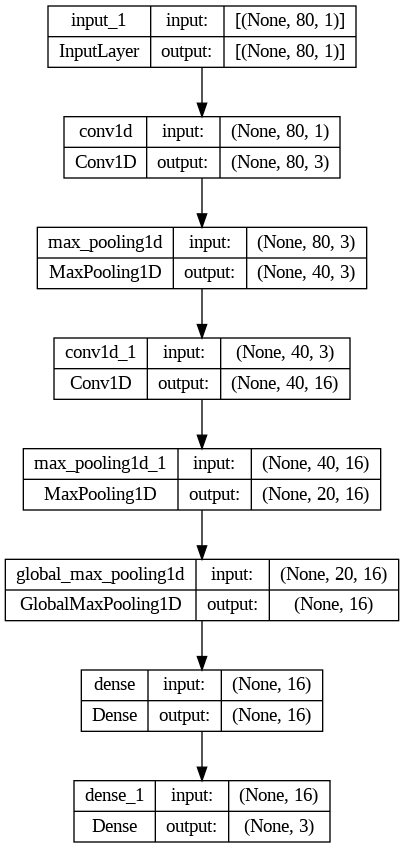

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_cnn, show_shapes=True, show_layer_names=True)

In [ ]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode ='max',
                          patience = 10, restore_best_weights = True)

history = model_cnn.fit(X_train_features, y_train, epochs = 200,
                       callbacks = [early_stop],
                       batch_size = 64, validation_data = (X_test_features, y_test))

Epoch 1/200
8/8 [==============================] - ETA: 0s - loss: 2.8098 - acc: 0.3313  

8/8 [==============================] - 13s 63ms/step - loss: 2.8098 - acc: 0.3313 - val_loss: 1.8495 - val_acc: 0.3333
Epoch 2/200
1/8 [==>...........................] - ETA: 0s - loss: 2.0583 - acc: 0.3281

8/8 [==============================] - 0s 11ms/step - loss: 1.4418 - acc: 0.5083 - val_loss: 1.0249 - val_acc: 0.6000
Epoch 3/200
1/8 [==>...........................] - ETA: 0s - loss: 1.2570 - acc: 0.5469

8/8 [==============================] - 0s 12ms/step - loss: 0.9067 - acc: 0.5833 - val_loss: 0.6627 - val_acc: 0.6333
Epoch 4/200
1/8 [==>...........................] - ETA: 0s - loss: 0.8278 - acc: 0.6250

8/8 [==============================] - 0s 11ms/step - loss: 0.5527 - acc: 0.6562 - val_loss: 0.4090 - val_acc: 0.6833
Epoch 5/200
1/8 [==>...........................] - ETA: 0s - loss: 0.4967 - acc: 0.5781

8/8 [==============================] - 0s 11ms/step - loss: 0.3625 - acc: 0.7521 - val_loss: 0.3025 - val_acc: 0.8250
Epoch 6/200
1/8 [==>...........................] - ETA: 0s - loss: 0.2479 - acc: 0.8906

8/8 [==============================] - 0s 12ms/step - loss: 0.2807 - acc: 0.8458 - val_loss: 0.2838 - val_acc: 0.8417
Epoch 7/200
1/8 [==>...........................] - ETA: 0s - loss: 0.2588 - acc: 0.8750

8/8 [==============================] - 0s 12ms/step - loss: 0.2519 - acc: 0.8771 - val_loss: 0.2512 - val_acc: 0.9000
Epoch 8/200
1/8 [==>...........................] - ETA: 0s - loss: 0.2339 - acc: 0.9062

8/8 [==============================] - 0s 12ms/step - loss: 0.2200 - acc: 0.8958 - val_loss: 0.2216 - val_acc: 0.9167
Epoch 9/200
1/8 [==>...........................] - ETA: 0s - loss: 0.1882 - acc: 0.9531

8/8 [==============================] - 0s 13ms/step - loss: 0.1977 - acc: 0.9167 - val_loss: 0.1930 - val_acc: 0.9417
Epoch 10/200
1/8 [==>...........................] - ETA: 0s - loss: 0.2082 - acc: 0.9219

8/8 [==============================] - 0s 13ms/step - loss: 0.1807 - acc: 0.9208 - val_loss: 0.1827 - val_acc: 0.9500
Epoch 11/200
1/8 [==>...........................] - ETA: 0s - loss: 0.2153 - acc: 0.8906

8/8 [==============================] - 0s 14ms/step - loss: 0.1639 - acc: 0.9312 - val_loss: 0.1658 - val_acc: 0.9417
Epoch 12/200
1/8 [==>...........................] - ETA: 0s - loss: 0.1774 - acc: 0.9531

8/8 [==============================] - 0s 13ms/step - loss: 0.1543 - acc: 0.9333 - val_loss: 0.1534 - val_acc: 0.9417
Epoch 13/200
1/8 [==>...........................] - ETA: 0s - loss: 0.1975 - acc: 0.9062

8/8 [==============================] - 0s 11ms/step - loss: 0.1439 - acc: 0.9417 - val_loss: 0.1476 - val_acc: 0.9417
Epoch 14/200
1/8 [==>...........................] - ETA: 0s - loss: 0.1138 - acc: 0.9531

8/8 [==============================] - 0s 12ms/step - loss: 0.1340 - acc: 0.9458 - val_loss: 0.1339 - val_acc: 0.9583
Epoch 15/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0995 - acc: 0.9844

8/8 [==============================] - 0s 10ms/step - loss: 0.1241 - acc: 0.9500 - val_loss: 0.1296 - val_acc: 0.9500
Epoch 16/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0970 - acc: 0.9531

8/8 [==============================] - 0s 12ms/step - loss: 0.1183 - acc: 0.9542 - val_loss: 0.1217 - val_acc: 0.9500
Epoch 17/200
1/8 [==>...........................] - ETA: 0s - loss: 0.1175 - acc: 0.9219

8/8 [==============================] - 0s 9ms/step - loss: 0.1112 - acc: 0.9542 - val_loss: 0.1163 - val_acc: 0.9500
Epoch 18/200
1/8 [==>...........................] - ETA: 0s - loss: 0.1165 - acc: 0.9531

8/8 [==============================] - 0s 9ms/step - loss: 0.1049 - acc: 0.9583 - val_loss: 0.1114 - val_acc: 0.9583
Epoch 19/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0695 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.1002 - acc: 0.9604 - val_loss: 0.1075 - val_acc: 0.9583
Epoch 20/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0933 - acc: 0.9844

8/8 [==============================] - 0s 11ms/step - loss: 0.0953 - acc: 0.9625 - val_loss: 0.1073 - val_acc: 0.9500
Epoch 21/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0650 - acc: 0.9844

8/8 [==============================] - 0s 9ms/step - loss: 0.0908 - acc: 0.9646 - val_loss: 0.1010 - val_acc: 0.9667
Epoch 22/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0971 - acc: 0.9531

8/8 [==============================] - 0s 9ms/step - loss: 0.0866 - acc: 0.9646 - val_loss: 0.1012 - val_acc: 0.9583
Epoch 23/200
1/8 [==>...........................] - ETA: 0s - loss: 0.1143 - acc: 0.9375

8/8 [==============================] - 0s 9ms/step - loss: 0.0827 - acc: 0.9708 - val_loss: 0.0965 - val_acc: 0.9667
Epoch 24/200
1/8 [==>...........................] - ETA: 0s - loss: 0.1048 - acc: 0.9844

8/8 [==============================] - 0s 11ms/step - loss: 0.0795 - acc: 0.9750 - val_loss: 0.0969 - val_acc: 0.9583
Epoch 25/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0624 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0755 - acc: 0.9771 - val_loss: 0.0915 - val_acc: 0.9667
Epoch 26/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0889 - acc: 0.9688

8/8 [==============================] - 0s 12ms/step - loss: 0.0729 - acc: 0.9729 - val_loss: 0.0908 - val_acc: 0.9667
Epoch 27/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0660 - acc: 0.9844

8/8 [==============================] - 0s 14ms/step - loss: 0.0699 - acc: 0.9792 - val_loss: 0.0903 - val_acc: 0.9667
Epoch 28/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0772 - acc: 0.9844

8/8 [==============================] - 0s 12ms/step - loss: 0.0668 - acc: 0.9792 - val_loss: 0.0875 - val_acc: 0.9750
Epoch 29/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0657 - acc: 0.9844

8/8 [==============================] - 0s 11ms/step - loss: 0.0648 - acc: 0.9750 - val_loss: 0.0864 - val_acc: 0.9667
Epoch 30/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0911 - acc: 0.9844

8/8 [==============================] - 0s 12ms/step - loss: 0.0625 - acc: 0.9792 - val_loss: 0.0834 - val_acc: 0.9750
Epoch 31/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0553 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0607 - acc: 0.9792 - val_loss: 0.0876 - val_acc: 0.9500
Epoch 32/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0425 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0576 - acc: 0.9812 - val_loss: 0.0796 - val_acc: 0.9833
Epoch 33/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0545 - acc: 0.9844

8/8 [==============================] - 0s 11ms/step - loss: 0.0567 - acc: 0.9812 - val_loss: 0.0834 - val_acc: 0.9667
Epoch 34/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0493 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0543 - acc: 0.9854 - val_loss: 0.0803 - val_acc: 0.9667
Epoch 35/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0713 - acc: 0.9844

8/8 [==============================] - 0s 12ms/step - loss: 0.0521 - acc: 0.9812 - val_loss: 0.0829 - val_acc: 0.9500
Epoch 36/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0454 - acc: 0.9688

8/8 [==============================] - 0s 10ms/step - loss: 0.0507 - acc: 0.9833 - val_loss: 0.0800 - val_acc: 0.9750
Epoch 37/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0402 - acc: 0.9844

8/8 [==============================] - 0s 9ms/step - loss: 0.0494 - acc: 0.9833 - val_loss: 0.0810 - val_acc: 0.9667
Epoch 38/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0723 - acc: 0.9688

8/8 [==============================] - 0s 11ms/step - loss: 0.0480 - acc: 0.9854 - val_loss: 0.0769 - val_acc: 0.9750
Epoch 39/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0177 - acc: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0467 - acc: 0.9875 - val_loss: 0.0823 - val_acc: 0.9583
Epoch 40/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0460 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0455 - acc: 0.9875 - val_loss: 0.0802 - val_acc: 0.9667
Epoch 41/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0400 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0440 - acc: 0.9875 - val_loss: 0.0778 - val_acc: 0.9667
Epoch 42/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0279 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0431 - acc: 0.9854 - val_loss: 0.0786 - val_acc: 0.9667
Epoch 43/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0331 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0421 - acc: 0.9875 - val_loss: 0.0801 - val_acc: 0.9667
Epoch 44/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0447 - acc: 0.9844

8/8 [==============================] - 0s 10ms/step - loss: 0.0419 - acc: 0.9833 - val_loss: 0.0794 - val_acc: 0.9667
Epoch 45/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0456 - acc: 0.9844

8/8 [==============================] - 0s 11ms/step - loss: 0.0400 - acc: 0.9875 - val_loss: 0.0761 - val_acc: 0.9667
Epoch 46/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0393 - acc: 0.9844

8/8 [==============================] - 0s 9ms/step - loss: 0.0390 - acc: 0.9875 - val_loss: 0.0829 - val_acc: 0.9667
Epoch 47/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0274 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0383 - acc: 0.9875 - val_loss: 0.0776 - val_acc: 0.9667
Epoch 48/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0434 - acc: 0.9844

8/8 [==============================] - 0s 8ms/step - loss: 0.0368 - acc: 0.9875 - val_loss: 0.0813 - val_acc: 0.9667
Epoch 49/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0257 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0355 - acc: 0.9896 - val_loss: 0.0810 - val_acc: 0.9667
Epoch 50/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0182 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0343 - acc: 0.9896 - val_loss: 0.0829 - val_acc: 0.9667
Epoch 51/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0178 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0334 - acc: 0.9896 - val_loss: 0.0810 - val_acc: 0.9667
Epoch 52/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0262 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0321 - acc: 0.9917 - val_loss: 0.0861 - val_acc: 0.9667
Epoch 53/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0291 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0312 - acc: 0.9937 - val_loss: 0.0762 - val_acc: 0.9667
Epoch 54/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0276 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0311 - acc: 0.9917 - val_loss: 0.0831 - val_acc: 0.9667
Epoch 55/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0229 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0304 - acc: 0.9917 - val_loss: 0.0829 - val_acc: 0.9667
Epoch 56/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0192 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0290 - acc: 0.9917 - val_loss: 0.0791 - val_acc: 0.9667
Epoch 57/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0207 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0281 - acc: 0.9937 - val_loss: 0.0872 - val_acc: 0.9583
Epoch 58/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0233 - acc: 0.9844

8/8 [==============================] - 0s 10ms/step - loss: 0.0279 - acc: 0.9937 - val_loss: 0.0816 - val_acc: 0.9667
Epoch 59/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0210 - acc: 0.9844

8/8 [==============================] - 0s 14ms/step - loss: 0.0267 - acc: 0.9937 - val_loss: 0.0867 - val_acc: 0.9667
Epoch 60/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0385 - acc: 0.9844

8/8 [==============================] - 0s 13ms/step - loss: 0.0267 - acc: 0.9937 - val_loss: 0.0843 - val_acc: 0.9667
Epoch 61/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0170 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0272 - acc: 0.9958 - val_loss: 0.0798 - val_acc: 0.9667
Epoch 62/200
8/8 [==============================] - ETA: 0s - loss: 0.0271 - acc: 0.9917

8/8 [==============================] - 0s 14ms/step - loss: 0.0271 - acc: 0.9917 - val_loss: 0.0895 - val_acc: 0.9583
Epoch 63/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0294 - acc: 0.9844

8/8 [==============================] - 0s 13ms/step - loss: 0.0248 - acc: 0.9958 - val_loss: 0.0775 - val_acc: 0.9667
Epoch 64/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0280 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0245 - acc: 0.9979 - val_loss: 0.0925 - val_acc: 0.9583
Epoch 65/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0243 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0237 - acc: 0.9937 - val_loss: 0.0785 - val_acc: 0.9667
Epoch 66/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0144 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0220 - acc: 0.9958 - val_loss: 0.0903 - val_acc: 0.9583
Epoch 67/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0122 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0222 - acc: 0.9958 - val_loss: 0.0819 - val_acc: 0.9667
Epoch 68/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0233 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0228 - acc: 0.9958 - val_loss: 0.0811 - val_acc: 0.9667
Epoch 69/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0147 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0207 - acc: 0.9937 - val_loss: 0.0888 - val_acc: 0.9583
Epoch 70/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0136 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0204 - acc: 0.9958 - val_loss: 0.0783 - val_acc: 0.9667
Epoch 71/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0148 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0199 - acc: 0.9958 - val_loss: 0.0814 - val_acc: 0.9667
Epoch 72/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0200 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0192 - acc: 0.9979 - val_loss: 0.0838 - val_acc: 0.9583
Epoch 73/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0190 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0190 - acc: 0.9979 - val_loss: 0.0836 - val_acc: 0.9667
Epoch 74/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0240 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0182 - acc: 0.9979 - val_loss: 0.0805 - val_acc: 0.9667
Epoch 75/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0174 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0176 - acc: 0.9979 - val_loss: 0.0829 - val_acc: 0.9583
Epoch 76/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0259 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0174 - acc: 0.9979 - val_loss: 0.0812 - val_acc: 0.9583
Epoch 77/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0133 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0172 - acc: 0.9979 - val_loss: 0.0811 - val_acc: 0.9583
Epoch 78/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0156 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0166 - acc: 0.9979 - val_loss: 0.0787 - val_acc: 0.9750
Epoch 79/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0167 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0164 - acc: 0.9979 - val_loss: 0.0815 - val_acc: 0.9583
Epoch 80/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0140 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0157 - acc: 0.9979 - val_loss: 0.0810 - val_acc: 0.9667
Epoch 81/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0139 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0153 - acc: 0.9979 - val_loss: 0.0803 - val_acc: 0.9667
Epoch 82/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0109 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0149 - acc: 0.9979 - val_loss: 0.0820 - val_acc: 0.9583
Epoch 83/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0143 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0147 - acc: 0.9979 - val_loss: 0.0788 - val_acc: 0.9750
Epoch 84/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0186 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0145 - acc: 0.9979 - val_loss: 0.0793 - val_acc: 0.9750
Epoch 85/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0233 - acc: 0.9844

8/8 [==============================] - 0s 9ms/step - loss: 0.0143 - acc: 0.9979 - val_loss: 0.0832 - val_acc: 0.9583
Epoch 86/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0171 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0140 - acc: 0.9979 - val_loss: 0.0788 - val_acc: 0.9667
Epoch 87/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0112 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0137 - acc: 0.9979 - val_loss: 0.0833 - val_acc: 0.9583
Epoch 88/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0141 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0129 - acc: 0.9979 - val_loss: 0.0754 - val_acc: 0.9750
Epoch 89/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0126 - acc: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0131 - acc: 0.9979 - val_loss: 0.0830 - val_acc: 0.9583
Epoch 90/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0087 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0125 - acc: 0.9979 - val_loss: 0.0794 - val_acc: 0.9583
Epoch 91/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0107 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0121 - acc: 0.9979 - val_loss: 0.0815 - val_acc: 0.9583
Epoch 92/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0087 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0120 - acc: 0.9979 - val_loss: 0.0813 - val_acc: 0.9583
Epoch 93/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0112 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0117 - acc: 0.9979 - val_loss: 0.0817 - val_acc: 0.9583
Epoch 94/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0198 - acc: 0.9844

8/8 [==============================] - 0s 14ms/step - loss: 0.0114 - acc: 0.9979 - val_loss: 0.0817 - val_acc: 0.9583
Epoch 95/200
5/8 [=================>............] - ETA: 0s - loss: 0.0107 - acc: 1.0000

8/8 [==============================] - 0s 42ms/step - loss: 0.0112 - acc: 0.9979 - val_loss: 0.0835 - val_acc: 0.9583
Epoch 96/200
4/8 [==============>...............] - ETA: 0s - loss: 0.0114 - acc: 1.0000

8/8 [==============================] - 0s 32ms/step - loss: 0.0109 - acc: 0.9979 - val_loss: 0.0800 - val_acc: 0.9583
Epoch 97/200
8/8 [==============================] - ETA: 0s - loss: 0.0108 - acc: 0.9979

8/8 [==============================] - 0s 15ms/step - loss: 0.0108 - acc: 0.9979 - val_loss: 0.0841 - val_acc: 0.9583
Epoch 98/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0055 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0104 - acc: 0.9979 - val_loss: 0.0839 - val_acc: 0.9583
Epoch 99/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0091 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0103 - acc: 0.9979 - val_loss: 0.0782 - val_acc: 0.9667
Epoch 100/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0111 - acc: 1.0000

8/8 [==============================] - 0s 14ms/step - loss: 0.0103 - acc: 0.9979 - val_loss: 0.0770 - val_acc: 0.9667
Epoch 101/200
8/8 [==============================] - ETA: 0s - loss: 0.0105 - acc: 0.9979

8/8 [==============================] - 0s 23ms/step - loss: 0.0105 - acc: 0.9979 - val_loss: 0.0855 - val_acc: 0.9583
Epoch 102/200
8/8 [==============================] - ETA: 0s - loss: 0.0098 - acc: 0.9979

8/8 [==============================] - 0s 46ms/step - loss: 0.0098 - acc: 0.9979 - val_loss: 0.0750 - val_acc: 0.9750
Epoch 103/200
7/8 [=========================>....] - ETA: 0s - loss: 0.0101 - acc: 0.9978

8/8 [==============================] - 0s 47ms/step - loss: 0.0097 - acc: 0.9979 - val_loss: 0.0860 - val_acc: 0.9583
Epoch 104/200
6/8 [=====================>........] - ETA: 0s - loss: 0.0101 - acc: 0.9974

8/8 [==============================] - 0s 38ms/step - loss: 0.0098 - acc: 0.9979 - val_loss: 0.0781 - val_acc: 0.9667
Epoch 105/200
7/8 [=========================>....] - ETA: 0s - loss: 0.0092 - acc: 0.9978

8/8 [==============================] - 0s 20ms/step - loss: 0.0096 - acc: 0.9979 - val_loss: 0.0839 - val_acc: 0.9583
Epoch 106/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0155 - acc: 0.9844

8/8 [==============================] - 0s 15ms/step - loss: 0.0088 - acc: 0.9979 - val_loss: 0.0750 - val_acc: 0.9667
Epoch 107/200
8/8 [==============================] - ETA: 0s - loss: 0.0090 - acc: 0.9979

8/8 [==============================] - 0s 17ms/step - loss: 0.0090 - acc: 0.9979 - val_loss: 0.0856 - val_acc: 0.9583
Epoch 108/200
8/8 [==============================] - ETA: 0s - loss: 0.0086 - acc: 0.9979

8/8 [==============================] - 1s 79ms/step - loss: 0.0086 - acc: 0.9979 - val_loss: 0.0782 - val_acc: 0.9667
Epoch 109/200
6/8 [=====================>........] - ETA: 0s - loss: 0.0086 - acc: 0.9974

8/8 [==============================] - 0s 54ms/step - loss: 0.0083 - acc: 0.9979 - val_loss: 0.0819 - val_acc: 0.9583
Epoch 110/200
5/8 [=================>............] - ETA: 0s - loss: 0.0090 - acc: 0.9969

8/8 [==============================] - 0s 22ms/step - loss: 0.0082 - acc: 0.9979 - val_loss: 0.0785 - val_acc: 0.9667
Epoch 111/200
8/8 [==============================] - ETA: 0s - loss: 0.0079 - acc: 0.9979

8/8 [==============================] - 0s 16ms/step - loss: 0.0079 - acc: 0.9979 - val_loss: 0.0833 - val_acc: 0.9583
Epoch 112/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0040 - acc: 1.0000

8/8 [==============================] - 0s 16ms/step - loss: 0.0079 - acc: 0.9979 - val_loss: 0.0824 - val_acc: 0.9583
Epoch 113/200
8/8 [==============================] - ETA: 0s - loss: 0.0077 - acc: 1.0000

8/8 [==============================] - 0s 17ms/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.0812 - val_acc: 0.9583
Epoch 114/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0043 - acc: 1.0000

8/8 [==============================] - 0s 14ms/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.0832 - val_acc: 0.9583
Epoch 115/200
8/8 [==============================] - ETA: 0s - loss: 0.0076 - acc: 1.0000

8/8 [==============================] - 0s 16ms/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.0794 - val_acc: 0.9583
Epoch 116/200
8/8 [==============================] - ETA: 0s - loss: 0.0073 - acc: 1.0000

8/8 [==============================] - 0s 18ms/step - loss: 0.0073 - acc: 1.0000 - val_loss: 0.0861 - val_acc: 0.9583
Epoch 117/200
7/8 [=========================>....] - ETA: 0s - loss: 0.0068 - acc: 1.0000

8/8 [==============================] - 0s 18ms/step - loss: 0.0071 - acc: 1.0000 - val_loss: 0.0792 - val_acc: 0.9583
Epoch 118/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0074 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.0855 - val_acc: 0.9583
Epoch 119/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0121 - acc: 1.0000

8/8 [==============================] - 0s 16ms/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0827 - val_acc: 0.9583
Epoch 120/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0036 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0830 - val_acc: 0.9583
Epoch 121/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0068 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0807 - val_acc: 0.9583
Epoch 122/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0082 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.0864 - val_acc: 0.9583
Epoch 123/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0052 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.0800 - val_acc: 0.9667
Epoch 124/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0050 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.0883 - val_acc: 0.9583
Epoch 125/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0055 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0833 - val_acc: 0.9583
Epoch 126/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0035 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0833 - val_acc: 0.9583
Epoch 127/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0050 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0840 - val_acc: 0.9583
Epoch 128/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0038 - acc: 1.0000

8/8 [==============================] - 0s 14ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0822 - val_acc: 0.9583
Epoch 129/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0041 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0840 - val_acc: 0.9583
Epoch 130/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0040 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0826 - val_acc: 0.9667
Epoch 131/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0023 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0856 - val_acc: 0.9583
Epoch 132/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0030 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0837 - val_acc: 0.9583
Epoch 133/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0044 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0840 - val_acc: 0.9583
Epoch 134/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0029 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0872 - val_acc: 0.9583
Epoch 135/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0035 - acc: 1.0000

8/8 [==============================] - 0s 15ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0840 - val_acc: 0.9667
Epoch 136/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0018 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0859 - val_acc: 0.9667
Epoch 137/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0049 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0881 - val_acc: 0.9583
Epoch 138/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0040 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0849 - val_acc: 0.9583
Epoch 139/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0029 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0869 - val_acc: 0.9583
Epoch 140/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0041 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0882 - val_acc: 0.9583
Epoch 141/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0037 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0834 - val_acc: 0.9667
Epoch 142/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0033 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0868 - val_acc: 0.9583
Epoch 143/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0019 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0879 - val_acc: 0.9583
Epoch 144/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0023 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0842 - val_acc: 0.9667
Epoch 145/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0030 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0889 - val_acc: 0.9583
Epoch 146/200
8/8 [==============================] - ETA: 0s - loss: 0.0042 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0910 - val_acc: 0.9583
Epoch 147/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0044 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0870 - val_acc: 0.9667
Epoch 148/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0035 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0869 - val_acc: 0.9667
Epoch 149/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0018 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0907 - val_acc: 0.9583
Epoch 150/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0028 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0830 - val_acc: 0.9667
Epoch 151/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0026 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0911 - val_acc: 0.9583
Epoch 152/200
7/8 [=========================>....] - ETA: 0s - loss: 0.0038 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0844 - val_acc: 0.9667
Epoch 153/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0025 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0884 - val_acc: 0.9667
Epoch 154/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0045 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0898 - val_acc: 0.9583
Epoch 155/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0032 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0896 - val_acc: 0.9667
Epoch 156/200
8/8 [==============================] - ETA: 0s - loss: 0.0034 - acc: 1.0000

8/8 [==============================] - 0s 15ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0886 - val_acc: 0.9667
Epoch 157/200
8/8 [==============================] - ETA: 0s - loss: 0.0034 - acc: 1.0000

8/8 [==============================] - 0s 17ms/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0871 - val_acc: 0.9667
Epoch 158/200
8/8 [==============================] - ETA: 0s - loss: 0.0033 - acc: 1.0000

8/8 [==============================] - 0s 14ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0897 - val_acc: 0.9667
Epoch 159/200
8/8 [==============================] - ETA: 0s - loss: 0.0033 - acc: 1.0000

8/8 [==============================] - 0s 17ms/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0896 - val_acc: 0.9667
Epoch 160/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0039 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0859 - val_acc: 0.9667
Epoch 161/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0029 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0873 - val_acc: 0.9667
Epoch 162/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0030 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0922 - val_acc: 0.9583
Epoch 163/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0036 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0881 - val_acc: 0.9667
Epoch 164/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0026 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0908 - val_acc: 0.9583
Epoch 165/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0018 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0846 - val_acc: 0.9667
Epoch 166/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0020 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0876 - val_acc: 0.9667
Epoch 167/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0025 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0907 - val_acc: 0.9583
Epoch 168/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0018 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0902 - val_acc: 0.9667
Epoch 169/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0032 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0828 - val_acc: 0.9667
Epoch 170/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0051 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0906 - val_acc: 0.9667
Epoch 171/200
1/8 [==>...........................] - ETA: 0s - loss: 6.3049e-04 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0914 - val_acc: 0.9667
Epoch 172/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0017 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0840 - val_acc: 0.9667
Epoch 173/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0025 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0932 - val_acc: 0.9583
Epoch 174/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0027 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0877 - val_acc: 0.9667
Epoch 175/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0047 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0893 - val_acc: 0.9667
Epoch 176/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0015 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0934 - val_acc: 0.9583
Epoch 177/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0031 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0883 - val_acc: 0.9667
Epoch 178/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0028 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0915 - val_acc: 0.9667
Epoch 179/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0015 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0930 - val_acc: 0.9583
Epoch 180/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0013 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0904 - val_acc: 0.9667
Epoch 181/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0035 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0878 - val_acc: 0.9667
Epoch 182/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0050 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0983 - val_acc: 0.9583
Epoch 183/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0024 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0859 - val_acc: 0.9667
Epoch 184/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0012 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0904 - val_acc: 0.9667
Epoch 185/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0031 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0919 - val_acc: 0.9667
Epoch 186/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0058 - acc: 1.0000

8/8 [==============================] - 0s 9ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0945 - val_acc: 0.9583
Epoch 187/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0015 - acc: 1.0000

8/8 [==============================] - 0s 8ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0853 - val_acc: 0.9667
Epoch 188/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0028 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0944 - val_acc: 0.9667
Epoch 189/200
1/8 [==>...........................] - ETA: 0s - loss: 8.7617e-04 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0920 - val_acc: 0.9667
Epoch 190/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0010 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0885 - val_acc: 0.9667
Epoch 191/200
1/8 [==>...........................] - ETA: 0s - loss: 8.8536e-04 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0896 - val_acc: 0.9667
Epoch 192/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0027 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0932 - val_acc: 0.9667
Epoch 193/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0019 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0925 - val_acc: 0.9667
Epoch 194/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0013 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0862 - val_acc: 0.9667
Epoch 195/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0014 - acc: 1.0000

8/8 [==============================] - 0s 13ms/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0936 - val_acc: 0.9667
Epoch 196/200
7/8 [=========================>....] - ETA: 0s - loss: 0.0019 - acc: 1.0000

8/8 [==============================] - 0s 14ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0892 - val_acc: 0.9667
Epoch 197/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0016 - acc: 1.0000

8/8 [==============================] - 0s 12ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0899 - val_acc: 0.9667
Epoch 198/200
1/8 [==>...........................] - ETA: 0s - loss: 9.9479e-04 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0919 - val_acc: 0.9667
Epoch 199/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0019 - acc: 1.0000

8/8 [==============================] - 0s 11ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0891 - val_acc: 0.9667
Epoch 200/200
1/8 [==>...........................] - ETA: 0s - loss: 0.0013 - acc: 1.0000

8/8 [==============================] - 0s 10ms/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0920 - val_acc: 0.9667


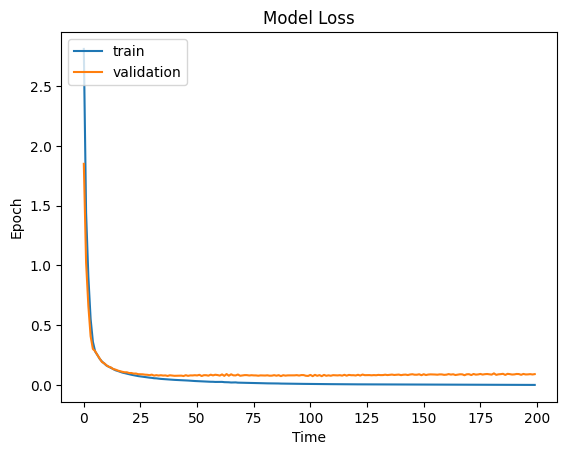

In [ ]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Time')
plt.ylabel('Epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [ ]:
_, acc = model_cnn.evaluate(X_test_features, y_test)
print("Test Accuracy : ", acc)

4/4 [==============================] - 0s 25ms/step - loss: 0.0920 - acc: 0.9667
Test Accuracy :  0.9666666388511658


4/4 [==============================] - 0s 5ms/step


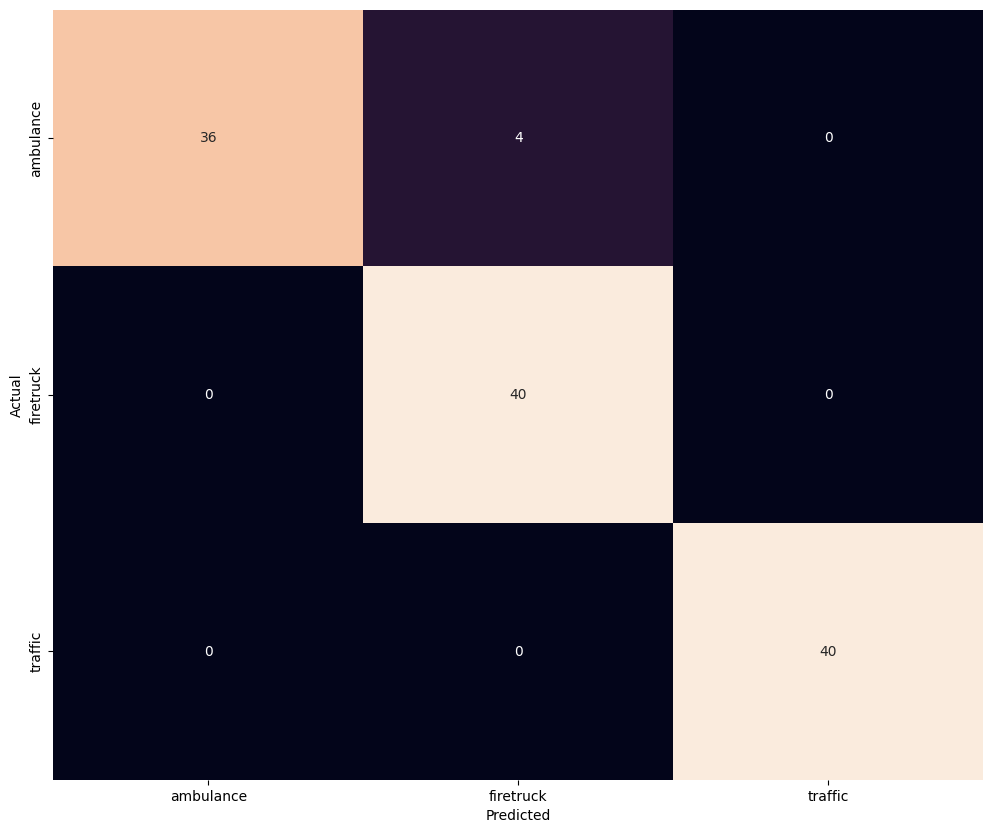

In [ ]:
y_pred = model_cnn.predict(X_test_features)

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
model_cnn.save('./CNN_Model')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('./CNN_Model')

In [ ]:
predictions = model.predict("/content/gdrive/MyDrive/SirenSound/sounds/firetruck/sound_201.wav")
predicted_class = np.argmax(predictions)
class_labels = ['ambulance', 'firetruck', 'traffic']
predicted_label = class_labels[predicted_class]
print("Predicted sound class:", predicted_label)


IndexError: ignored

In [ ]:
import tensorflow as tf

# Load the SavedModel
loaded_model = tf.keras.models.load_model('./CNN_Model')

# Save as an .h5 file
loaded_model.save('./CNN_Model.h5')

In [ ]:
import librosa
import tensorflow as tf
import numpy as np

# Load your trained model
model = tf.keras.models.load_model('/content/best_model.hdf5')

# Function to preprocess audio
def preprocess_audio(audio, sr):
    # Convert audio to mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
    # Resize the spectrogram to match the input shape of the model
    mel_spec = np.resize(mel_spec, (1, 1, 80))
    return mel_spec

# Function to classify audio
def classify_audio(audio, sr):
    preprocessed_audio = preprocess_audio(audio, sr)
    # Make predictions
    predictions = model.predict(preprocessed_audio)
    # Get the predicted class
    predicted_class = np.argmax(predictions)
    # Map the class index to its corresponding label
    class_labels = ['ambulance','traffic','firetruck']
    predicted_label = class_labels[predicted_class]
    return predicted_label

# Specify the path to your audio file
audio_file_path = '/content/videoplayback4.wav'

# Load the audio file
audio, sr = librosa.load(audio_file_path, sr=44100)

# Classify the audio
predicted_label = classify_audio(audio, sr)
print("Predicted sound class:", predicted_label)



1/1 [==============================] - 1s 572ms/step
Predicted sound class: firetruck


In [ ]:
import librosa
import numpy as np
import tensorflow as tf
from keras.models import load_model
import tensorflow as tf

# Load the SavedModel
loaded_model = tf.keras.models.load_model('./CNN_Model')


# Load the trained model
model_cnn = loaded_model

# Function to extract MFCC features from audio window
def extract_features_from_window(audio_window):
    mfccs_features = librosa.feature.mfcc(y=audio_window, sr=sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

# Set up the streaming parameters
sample_rate = 22050  # Adjust this based on your audio data
window_size = int(sample_rate * 1)  # 1 second window size
stride = int(window_size / 2)  # 50% overlap between consecutive windows

# Function to perform real-time sound classification
def real_time_sound_classification(audio_stream):
    audio_stream = audio_stream.astype(np.float32)
    num_windows = (len(audio_stream) - window_size) // stride + 1
    predictions = []

    for i in range(num_windows):
        start = i * stride
        end = start + window_size
        audio_window = audio_stream[start:end]

        # Extract features from the audio window
        features = extract_features_from_window(audio_window)
        features = features.reshape(1, -1, 1)

        # Make predictions using the CNN model
        prediction = model_cnn.predict(features)
        predictions.append(prediction)

    return np.array(predictions)

# Example usage (replace with streaming audio input)
# Assume you have a streaming audio input called 'audio_input'
# You need to adapt this part to capture the real-time audio stream
#audio_input = "/content/gdrive/MyDrive/SirenSound/sounds/ambulance/sound_1.wav"
audio_file_path = '/content/gdrive/MyDrive/SirenSound/sounds/ambulance/sound_1.wav'

# Load the audio file
audio_input, sr = librosa.load(audio_file_path, sr=44100)

for audio_data in audio_input:
    # Perform real-time sound classification
    predictions = real_time_sound_classification(audio_data)

    # Calculate the final prediction based on the majority vote (e.g., taking the mode)
    final_prediction = np.argmax(np.mean(predictions, axis=0))
    class_label = labelencoder.inverse_transform([final_prediction])[0]
    print("Real-time prediction:", class_label)


TypeError: ignored

In [ ]:
!pip install sounddevice
!pip install soundfile


In [ ]:
!apt-get install -y libportaudio2
!pip install sounddevice

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 65.3 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Fetched 65.3 kB in 0s (296 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 120509 files and directories currently installed.)
Preparing to unpack .../libportaudio2_19.6.0-1.1_amd64.deb ...
Unpacking libportaudio2:amd64 (19.6.0-1.1) ...
Setting up libportaudio2:amd64 (19.6.0-1.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...


In [ ]:
from sounddevice import query_devices
print(query_devices())

In [ ]:
import sounddevice as sd
import numpy as np
import librosa
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Load the SavedModel
loaded_model = tf.keras.models.load_model('./CNN_Model')


# Load the trained model
model = loaded_model

def extract_mfcc_features(audio_chunk, sample_rate):
    mfccs_features = librosa.feature.mfcc(y=audio_chunk, sr=sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

def audio_callback(indata, frames, time, status):
    # Extract MFCC features from the audio chunk
    mfccs = extract_mfcc_features(indata[:, 0], sample_rate)
    # Reshape the data to match the input shape of the CNN model
    mfccs = mfccs.reshape(1, -1, 1)
    # Make a prediction using the CNN model
    prediction = model.predict(mfccs)
    # Get the class label with the highest probability
    class_index = np.argmax(prediction)
    predicted_class = labelencoder.inverse_transform([class_index])[0]
    print("Predicted Class:", predicted_class)

# Load label encoder for inverse transforming predictions
labelencoder = LabelEncoder()
labelencoder.classes_ = np.array(['ambulances', 'firetrucks', 'traffic'])

# Set the sample rate and chunk size (adjust as needed)
sample_rate = 22050
chunk_size = 1024

# Start the audio stream with the microphone as input
stream = sd.InputStream(callback=audio_callback, channels=1, samplerate=sample_rate, blocksize=chunk_size)
with stream:
    print("Listening for audio input...")
    while True:
        pass


PortAudioError: ignored